In [1516]:
import numpy as np
import pandas as pd

In [1517]:
players=pd.read_csv('vorp.csv')
stats=pd.read_csv('nba_players_adv_other_stats.csv')
clusters=pd.read_csv('nba_clusters_full_types.csv')

In [1518]:
players[players['Player_Upper']=='MIKE JAMES2']

,Player_Upper,id,year,VORP,Min,league,flag,lockout,is_euroleague,dum,calc,to_delete,scale,to_delete_nba,success
2286,MIKE JAMES2,MIKE JAMES22020-2021,2020-2021,-0.100000,236.0,NBA,1,0,0,1,-1,0,0,0,1
2287,MIKE JAMES2,MIKE JAMES22021-2022,2021-2022,1.615447,872.0,EUR,0,0,0,2,1,0,1,0,1
2288,MIKE JAMES2,MIKE JAMES22021-2022,2021-2022,3.188819,1185.0,EUR,0,0,1,2,0,0,2,0,1


In [1519]:
players['second_stint']=players['Player_Upper'].apply(lambda x: 1 if '2' in x else 0)

In [1520]:
players['Player_Upper']=players['Player_Upper'].str.replace('2','')
players['id']=players['id'].str.replace('220','20')

In [1521]:
stats['id']=stats['Player']+stats['year']

In [1522]:
players=players[players['scale']==0]

In [1523]:
players=players.merge(stats[['id','exp','Career stage','recruiting_rank','division','rank_labels','draft_labels','draft_round']],left_on='id',right_on='id',how='left')

In [1524]:
players=players.merge(clusters[['id','player type']],left_on='id',right_on='id',how='left')

In [1525]:
players.loc[players['second_stint']==1,'Player_Upper']=players.loc[players['second_stint']==1,'Player_Upper']+'2'

In [1526]:
players['id']=players['Player_Upper']+players['year']

In [1527]:
players.columns

Index(['Player_Upper', 'id', 'year', 'VORP', 'Min', 'league', 'flag',
       'lockout', 'is_euroleague', 'dum', 'calc', 'to_delete', 'scale',
       'to_delete_nba', 'success', 'second_stint', 'exp', 'Career stage',
       'recruiting_rank', 'division', 'rank_labels', 'draft_labels',
       'draft_round', 'player type'],
      dtype='object')

In [1528]:
players=players[['id', 'VORP', 'Min','success', 'exp', 'Career stage', 'division', 'rank_labels', 'draft_labels','draft_round', 'player type']]

In [1529]:
players

,id,VORP,Min,success,exp,Career stage,division,rank_labels,draft_labels,draft_round,player type
0,A.J. GUYTON2001-2002,0.1,607.0,0,2,Improving End-of-Bench,NCAA D1,no rank,Mid 20,2.0,High Usage Guard
1,AARON HARRISON2017-2018,-0.3,233.0,1,3,Improving End-of-Bench,NCAA D1,Top 20,undrafted,undrafted,Role player
2,ACIE LAW2010-2011,-0.4,726.0,1,4,Improving End-of-Bench,NCAA D1,no rank,Top 20,1.0,Floor General
3,ADAM MORRISON2009-2010,-0.2,241.0,1,3,Improving End-of-Bench,NCAA D1,no rank,Top 20,1.0,Floor General
4,ADREIAN PAYNE2015-2016,-0.5,486.0,1,2,Improving End-of-Bench,NCAA D1,Mid,Top 20,1.0,Skilled Role player
...,...,...,...,...,...,...,...,...,...,...,...
494,YAKHOUBA DIAWARA2008-2009,-0.5,851.0,1,3,Improving End-of-Bench,NCAA D1,no rank,undrafted,undrafted,3PT specialist
495,YOGI FERRELL2019-2020,0.0,530.0,0,4,Improving End-of-Bench,NCAA D1,Mid,undrafted,undrafted,High Usage Guard
496,ZABIAN DOWDELL2010-2011,-0.1,292.0,1,1,Improving End-of-Bench,NCAA D1,no rank,undrafted,undrafted,Role player
497,ZAN TABAK2000-2001,-0.4,777.0,1,6,Past Prime,Europe,no rank,Bottom 20,2.0,Traditional Center


In [1530]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [1531]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [1532]:
players['rank_labels'].replace(['Top 20'], 1,inplace=True)
players['rank_labels'].replace(['Mid'], 2,inplace=True)
players['rank_labels'].replace(['Bottom'], 3,inplace=True)
players['rank_labels'].replace(['no rank'], 4,inplace=True)

In [1533]:
players['draft_labels'].replace(['Top 20'], 0,inplace=True)
players['draft_labels'].replace(['Mid 20'], 1,inplace=True)
players['draft_labels'].replace(['Bottom 20'], 2,inplace=True)
players['draft_labels'].replace(['undrafted'], 3,inplace=True)

In [1534]:
players['draft_round'].replace(['undrafted'], 3,inplace=True)

In [1535]:
players.groupby('success').mean()

,VORP,Min,exp,rank_labels,draft_labels
success,,,,,
0,-0.065089,590.656805,4.810651,3.355030,1.668639
1,-0.152727,537.333333,3.021212,3.372727,1.630303


In [1536]:
pd.DataFrame(players.groupby('rank_labels')['success'].value_counts())

success
rank_labels success         
1           1             37
            0             20
2           1             37
            0             18
3           1             22
            0             13
4           1            234
            0            118

In [1537]:
pd.DataFrame(players.groupby('draft_labels')['success'].value_counts())

success
draft_labels success         
0            1             55
             0             36
1            1            116
             0             43
2            1             55
             0             31
3            1            104
             0             59

In [1538]:
pd.DataFrame(players.groupby('Career stage')['success'].value_counts())

success
Career stage           success         
Improving End-of-Bench 1            237
                       0             86
Improving Role Player  1             46
                       0             16
Past Prime             0             67
                       1             47

In [1539]:
pd.DataFrame(players.groupby('division')['success'].value_counts())

success
division                     success         
Community College/Not Listed 1              3
                             0              2
Europe                       1             81
                             0             28
High School                  0              1
                             1              1
NCAA D1                      1            244
                             0            135
NCAA D2                      0              3
NCAA D3                      1              1

In [1540]:
pd.DataFrame(players.groupby('draft_round')['success'].value_counts())

success
draft_round success         
3           1            104
            0             59
1.0         1            115
            0             59
2.0         1            111
            0             51

In [1541]:
type_groups=pd.DataFrame(players.groupby('player type')['success'].value_counts())
type_groups

success
player type          success         
3PT specialist       1             44
                     0             27
Ball Dominant Scorer 1              7
                     0              3
Defensive specialist 1             19
                     0             10
Floor General        1             44
                     0             19
High Usage Guard     1             47
                     0             30
Role player          1             54
                     0             32
Skilled Big          1              7
                     0              4
Skilled Forward      1             16
                     0              4
Skilled Role player  1             33
                     0             21
Traditional Center   1             59
                     0             19

In [1434]:
players[players['player type']=='Ball Dominant Scorer']

,id,VORP,Min,success,exp,Career stage,division,rank_labels,draft_labels,draft_round,player type
13,ALEXEY SHVED2014-2015,0.9,767.0,1,3,Improving Role Player,Europe,4,3,3,Ball Dominant Scorer
21,ANDREW GOUDELOCK2011-2012,-0.3,419.0,1,1,Improving End-of-Bench,NCAA D1,4,2,2.0,Ball Dominant Scorer
43,BOBBY BROWN2009-2010,-0.4,519.0,1,2,Improving End-of-Bench,NCAA D1,4,3,3,Ball Dominant Scorer
126,DION GLOVER2003-2004,0.0,1643.0,0,5,Improving Role Player,NCAA D1,4,0,1.0,Ball Dominant Scorer
182,J.J. BAREA2019-2020,0.1,450.0,0,14,Past Prime,NCAA D1,4,3,3,Ball Dominant Scorer
246,JORDAN MCRAE2019-2020,0.1,784.0,0,4,Past Prime,NCAA D1,2,2,2.0,Ball Dominant Scorer
282,LAVOR POSTELL2001-2002,-0.1,179.0,1,2,Improving End-of-Bench,NCAA D1,4,1,2.0,Ball Dominant Scorer
306,MANNY HARRIS2011-2012,0.0,456.0,1,2,Improving End-of-Bench,NCAA D1,2,3,3,Ball Dominant Scorer
333,MIKE JAMES2017-2018,0.1,687.0,1,1,Improving End-of-Bench,NCAA D1,4,3,3,Ball Dominant Scorer
462,TONY WROTEN2015-2016,-0.4,144.0,1,4,Improving End-of-Bench,NCAA D1,1,1,1.0,Ball Dominant Scorer


In [1436]:
players=pd.get_dummies(players, columns=['player type','Career stage','division'],drop_first=True)

In [1437]:
players['draft_labels'] = players['draft_labels'].apply(pd.to_numeric, errors='coerce')
players['rank_labels'] = players['rank_labels'].apply(pd.to_numeric, errors='coerce')
players['draft_round'] = players['draft_round'].apply(pd.to_numeric, errors='coerce')

In [1438]:
to_scale=players[['VORP','Min','exp']]

In [1439]:
trans = MinMaxScaler()
players_scaled = trans.fit_transform(to_scale)

In [1440]:
players_scaled=pd.DataFrame(players_scaled,columns=to_scale.columns)

In [1441]:
players.drop(columns=['VORP','Min','exp'],inplace=True)
players=pd.concat([players,players_scaled],axis=1)

In [1442]:
players=players.drop(columns=['division_Europe', 'division_High School', 'division_NCAA D1','division_NCAA D2', 'division_NCAA D3','draft_round'])

In [1443]:
y=players['success']
x=sm.add_constant(players.drop(columns=['success','id']))

In [1444]:
x.rename(columns={'const':'intercept','VORP':'VORP - Last season in the NBA','Min':'Minutes Played - Last season in the NBA','exp':'Experience','rank_labels':'Recruiting Rank category','draft_labels':'Draft Position category'},inplace=True)

In [1445]:
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.575094
         Iterations 5
                                    Results: Logit
Model:                      Logit                   Pseudo R-squared:        0.102     
Dependent Variable:         success                 AIC:                     607.9437  
Date:                       2022-09-22 19:13        BIC:                     679.5580  
No. Observations:           499                     Log-Likelihood:          -286.97   
Df Model:                   16                      LL-Null:                 -319.44   
Df Residuals:               482                     LLR p-value:             7.5730e-08
Converged:                  1.0000                  Scale:                   1.0000    
No. Iterations:             5.0000                                                     
---------------------------------------------------------------------------------------
                                         Coef.  Std.Err

In [1460]:
hypotheses = '(player type_Ball Dominant Scorer = 0), (player type_Defensive specialist = 0), (player type_Floor General  = 0), (player type_High Usage Guard = 0), (player type_Role player = 0), (player type_Skilled Big = 0), (player type_Skilled Forward = 0), (player type_Skilled Role player = 0), (player type_Traditional Center = 0)'
f_test = result.f_test(hypotheses)
print(f_test)

<F test: F=0.43190870095783995, p=0.9178935373551794, df_denom=482, df_num=9>


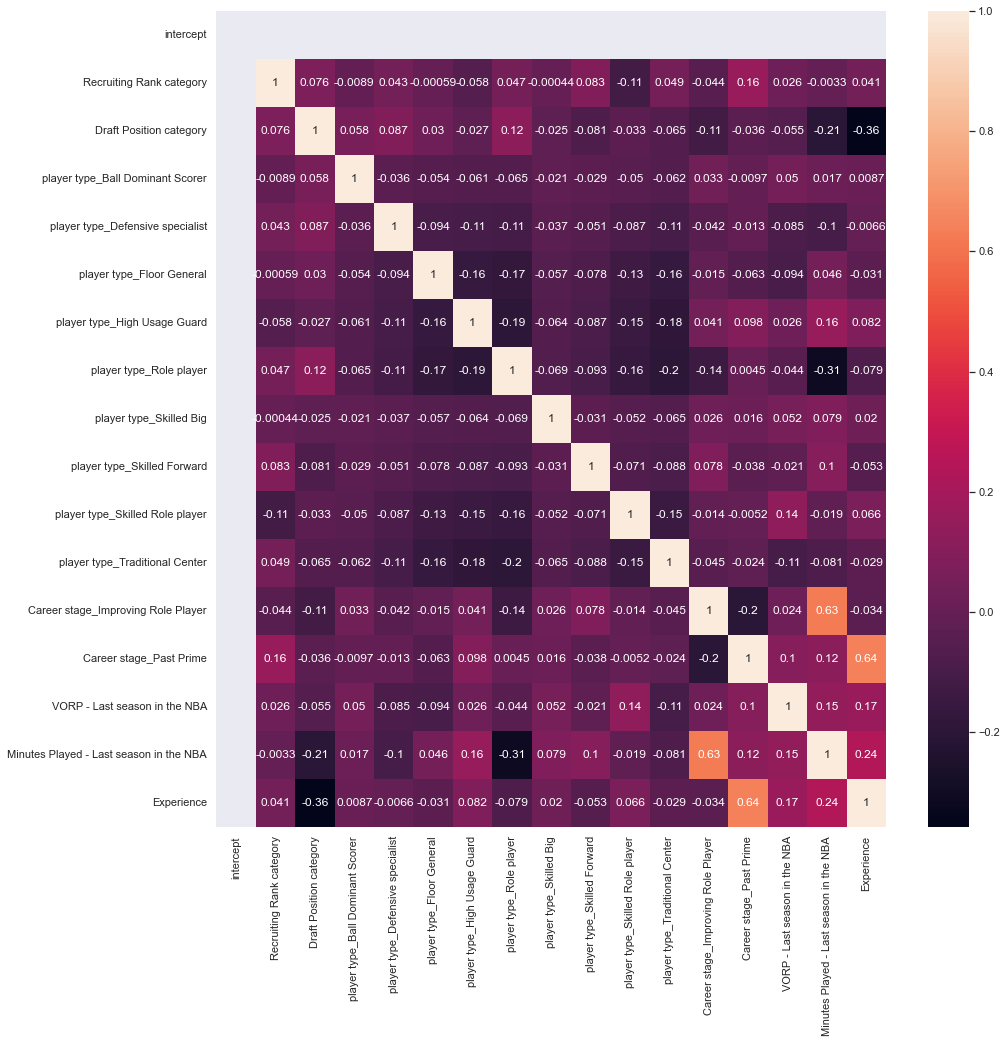

In [1461]:
import seaborn as sns
import matplotlib.pyplot as plt


corrMatrix = x.corr()
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [1462]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_scores = pd.DataFrame() 
vif_scores["Attribute"] = x.columns 
  
# calculating VIF for each feature 
vif_scores["VIF Scores"] = [variance_inflation_factor(x.values, i) for i in range(len(x.columns))] 
  
display(vif_scores)

,Attribute,VIF Scores
0,intercept,39.421405
1,Recruiting Rank category,1.070619
2,Draft Position category,1.308126
3,player type_Ball Dominant Scorer,1.130524
4,player type_Defensive specialist,1.418733
5,player type_Floor General,1.717982
6,player type_High Usage Guard,1.789233
7,player type_Role player,2.103517
8,player type_Skilled Big,1.130808
9,player type_Skilled Forward,1.256823


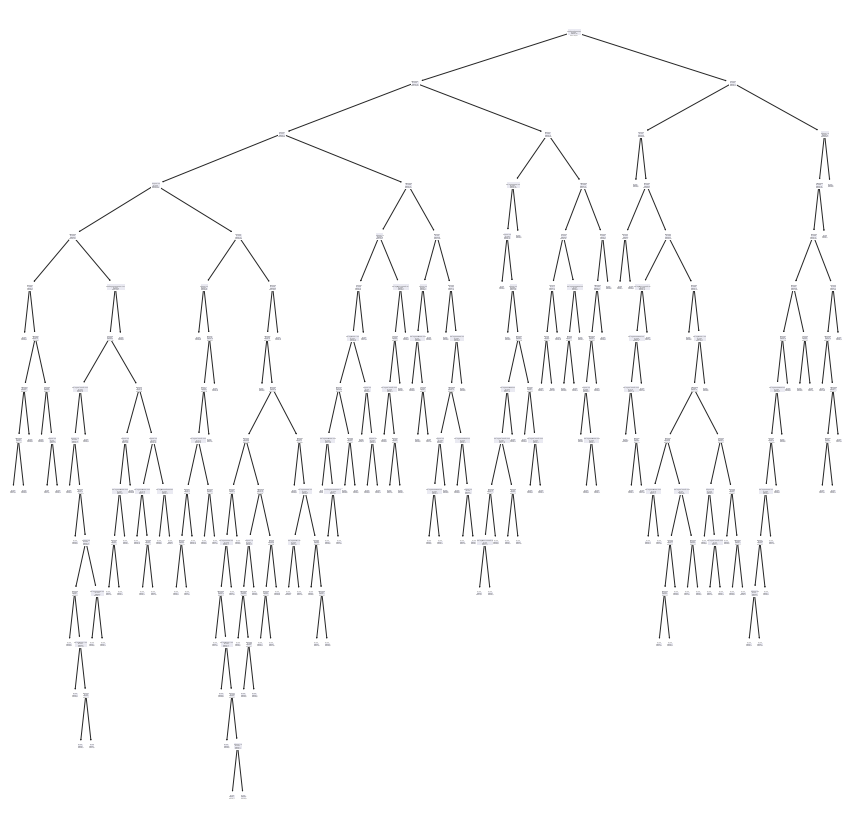

In [1189]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier()
dtree = dtree.fit(x, y)

tree.plot_tree(dtree,feature_names=x.columns)
plt.gcf()
plt.savefig('out.pdf')
plt.show()

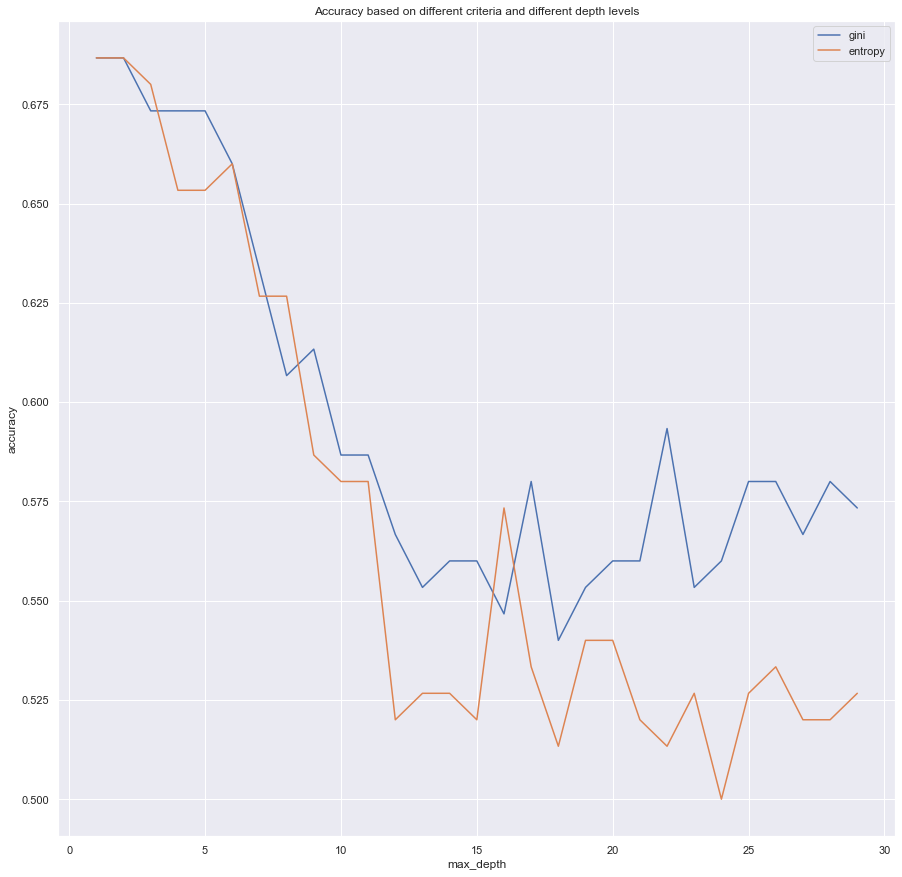

In [1359]:
from sklearn.metrics import accuracy_score
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_gini.append(accuracy_score(y_test, pred))

    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    dtree.fit(X_train, y_train)
    pred = dtree.predict(X_test)
    acc_entropy.append(accuracy_score(y_test, pred))

    max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Accuracy based on different criteria and different depth levels')
plt.legend()

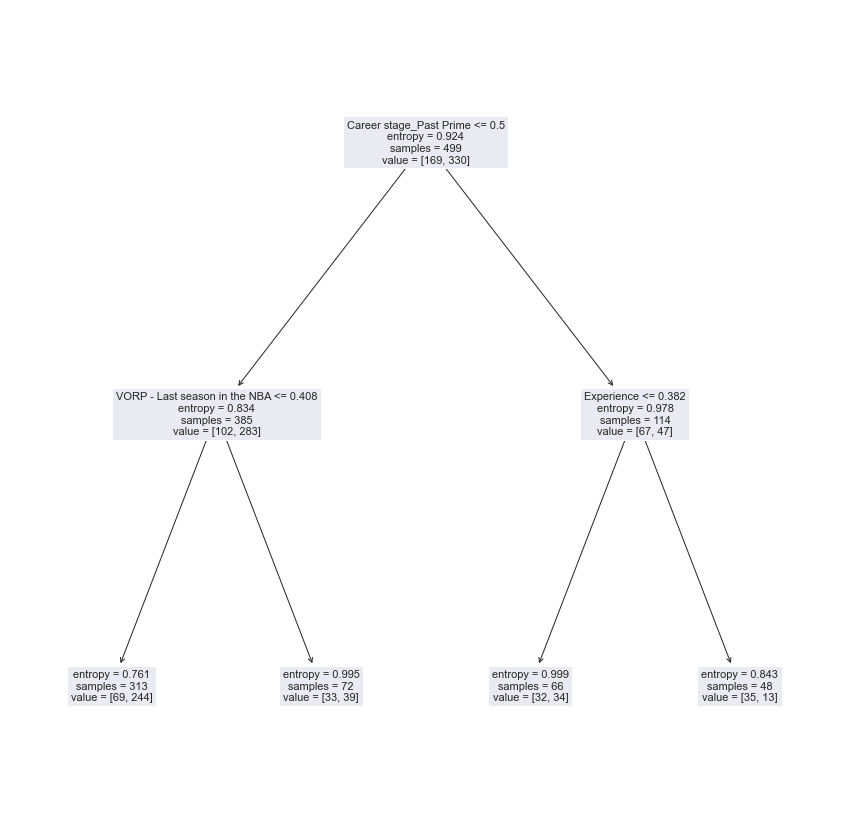

In [1360]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth=2,criterion='entropy')
dtree = dtree.fit(x, y)

tree.plot_tree(dtree,feature_names=x.columns)
plt.gcf()
plt.savefig('out.pdf')
plt.show()

In [1463]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [1464]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.70


In [1465]:
y_pred

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1], dtype=int64)

In [1466]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print('Confusion matrix')
print(confusion_matrix)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Confusion matrix
[[19 35]
 [10 86]]
Accuracy of logistic regression classifier on test set: 0.70


In [1467]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.35      0.46        54
           1       0.71      0.90      0.79        96

    accuracy                           0.70       150
   macro avg       0.68      0.62      0.63       150
weighted avg       0.69      0.70      0.67       150



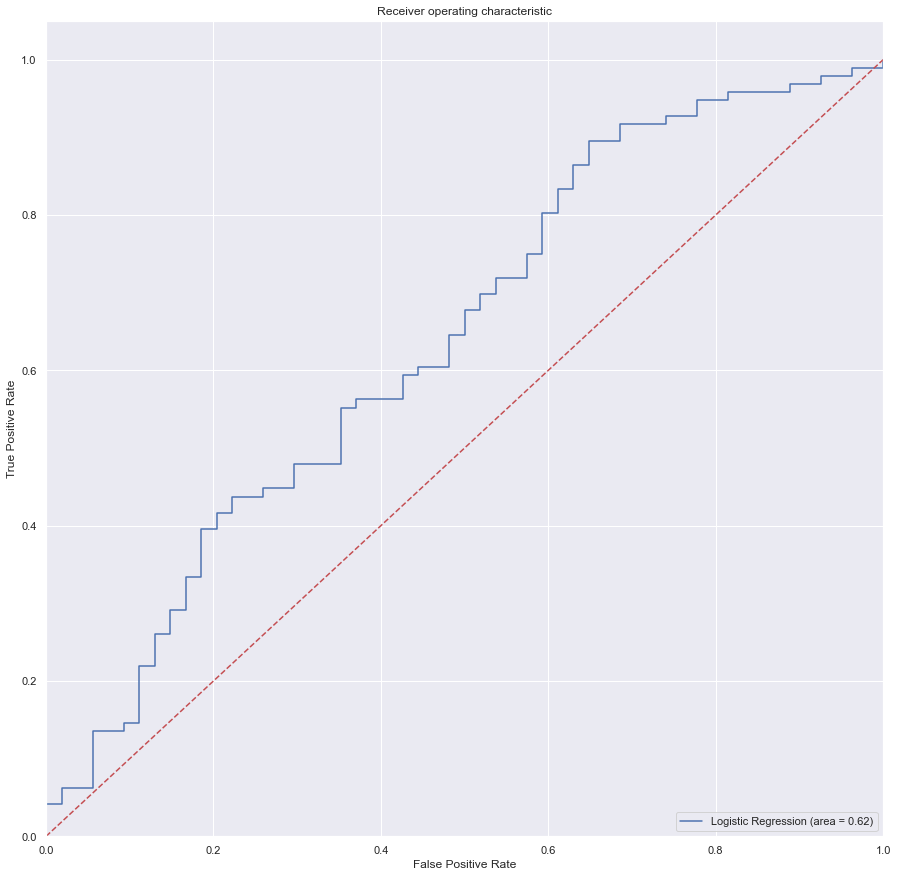

In [1468]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [1491]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

In [1500]:
def clf_performance(classifier, model_name):
    print(model_name)
    print('Best Score: ' + str(classifier.best_score_))
    print('Best Parameters: ' + str(classifier.best_params_))

In [1493]:
# Naive Bayes
gnb = GaussianNB()
model = gnb.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.68
0.6203703703703705


In [1494]:
# Logistic Regression
lr = LogisticRegression(max_iter = 2000)
model = lr.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))



0.7
0.6238425925925926


In [1495]:
# Decision Tree
dt = tree.DecisionTreeClassifier(random_state = 1)
model = dt.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.5733333333333334
0.5410879629629629


In [1496]:
# K Nearest Neighbors
knn = KNeighborsClassifier()
model = knn.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.66
0.5804398148148149


In [1497]:
# Random Forest
rf = RandomForestClassifier(random_state = 1)
model = rf.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.6333333333333333
0.5677083333333334


In [1498]:
# Support Vector Classifier
svc = SVC(probability = True)
model = svc.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.6866666666666666
0.6012731481481481


In [1499]:
# Xtreme Gradient Boosting
xgb = XGBClassifier(random_state =1,eval_metric="logloss")
model = xgb.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.6466666666666666
0.6186342592592593


#### Out of Sample Accuracy
|Model|Accuracy|AUC Score|
|-----|--------|---------|
|Naive Bayes| 68.0% |0.620|
|**Logistic Regression**| **70.0%**|0.624|
|Decision Tree| 57.3%|0.541|
|K Nearest Neighbor| 66.0%|0.580|
|Random Forest| 63.3%|0.568|
|Support Vector Classifier| 68.6%|0.601|
|Xtreme Gradient Boosting| 64.6%|0.619|

In [1502]:
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

In [1503]:
lr = LogisticRegression()
param_grid = {'max_iter' : [5,100,500,100,2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_lr = clf_lr.fit(X_train,y_train)
clf_performance(best_clf_lr,'Logistic Regression')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Logistic Regression
Best Score: 0.6990476190476189
Best Parameters: {'C': 0.615848211066026, 'max_iter': 5, 'penalty': 'l1', 'solver': 'liblinear'}


C:\Users\marli\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [1509]:
lr = LogisticRegression(max_iter=5,
              penalty='l1',
              C=0.615,
              solver='liblinear')
model = lr.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.6933333333333334
0.6145833333333334


C:\Users\marli\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [1504]:
knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : [3,5,7,9],
              'weights' : ['uniform', 'distance'],
              'algorithm' : ['auto', 'ball_tree','kd_tree'],
              'p' : [1,2]}
clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train,y_train)
clf_performance(best_clf_knn,'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.6591304347826086
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}


In [1510]:
knn = KNeighborsClassifier(algorithm='auto',n_neighbors=9,p=2,weights='uniform')
model = knn.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.64
0.5567129629629629


In [1505]:
rf = RandomForestClassifier(random_state = 1)
param_grid =  {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [130, 180, 230]}
                                  
clf_rf_rnd = RandomizedSearchCV(rf, param_distributions = param_grid, n_iter = 100, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf_rnd.fit(X_train,y_train)
clf_performance(best_clf_rf,'Random Forest')

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Random Forest
Best Score: 0.6933333333333332
Best Parameters: {'n_estimators': 130, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 70, 'bootstrap': True}


In [1511]:
rf = RandomForestClassifier(random_state = 1,n_estimators=130,min_samples_split=10,min_samples_leaf=4,max_features='auto',max_depth=70,bootstrap=True)
model = rf.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.6866666666666666
0.6053240740740742


In [1506]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'], 'gamma': [.1,.5,1,2,5,10],
                                  'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['linear'], 'C': [.1, 1, 10, 100, 1000]},
                                 {'kernel': ['poly'], 'degree' : [2,3,4,5], 'C': [.1, 1, 10, 100, 1000]}]
clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train,y_train)
clf_performance(best_clf_svc,'SVC')

Fitting 5 folds for each of 55 candidates, totalling 275 fits
SVC
Best Score: 0.7077846790890269
Best Parameters: {'C': 1, 'degree': 3, 'kernel': 'poly'}


In [1512]:
svc = SVC(probability = True,C=1,degree=3,kernel='poly')
model = svc.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.7
0.6278935185185185


In [1507]:
xgb = XGBClassifier(random_state = 1,eval_metric="logloss")

param_grid = {
    'booster':['gbtree','gblinear'],
              'learning_rate': [0.1], 
              'max_depth': [7,10,15,20],
              'min_child_weight': [10,15,20,25],
              'colsample_bytree': [0.8, 0.9, 1],
              'n_estimators': [300,400,500,600],
              "reg_alpha"   : [0.5,0.2,1],
              "reg_lambda"  : [2,3,5],
              "gamma"       : [1,2,3],
}

clf_xgb_rnd = RandomizedSearchCV(xgb, param_distributions = param_grid, n_iter = 500, cv = 3, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb_rnd.fit(X_train,y_train)
clf_performance(best_clf_xgb,'XGB')

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
XGB
Best Score: 0.7106297278711072
Best Parameters: {'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 7, 'learning_rate': 0.1, 'gamma': 2, 'colsample_bytree': 0.9, 'booster': 'gbtree'}


In [1513]:
xgb = XGBClassifier(random_state =1,eval_metric="logloss",reg_lambda=5,reg_alpha=0.5,n_estimators=500,min_child_weight=10,max_depth=7,learning_rate=0.1,gamma=2,colsample_bytree=0.9,booster='gbtree')
model = xgb.fit(X_train,y_train)

yhat = model.predict(X_test)

acc = accuracy_score(y_test, yhat)
print(acc)
print(roc_auc_score(y_test, yhat))

0.6866666666666666
0.609375


In [1545]:
type_groups.rename(columns={'success':'n'},inplace=True)
type_groups.reset_index(inplace=True)

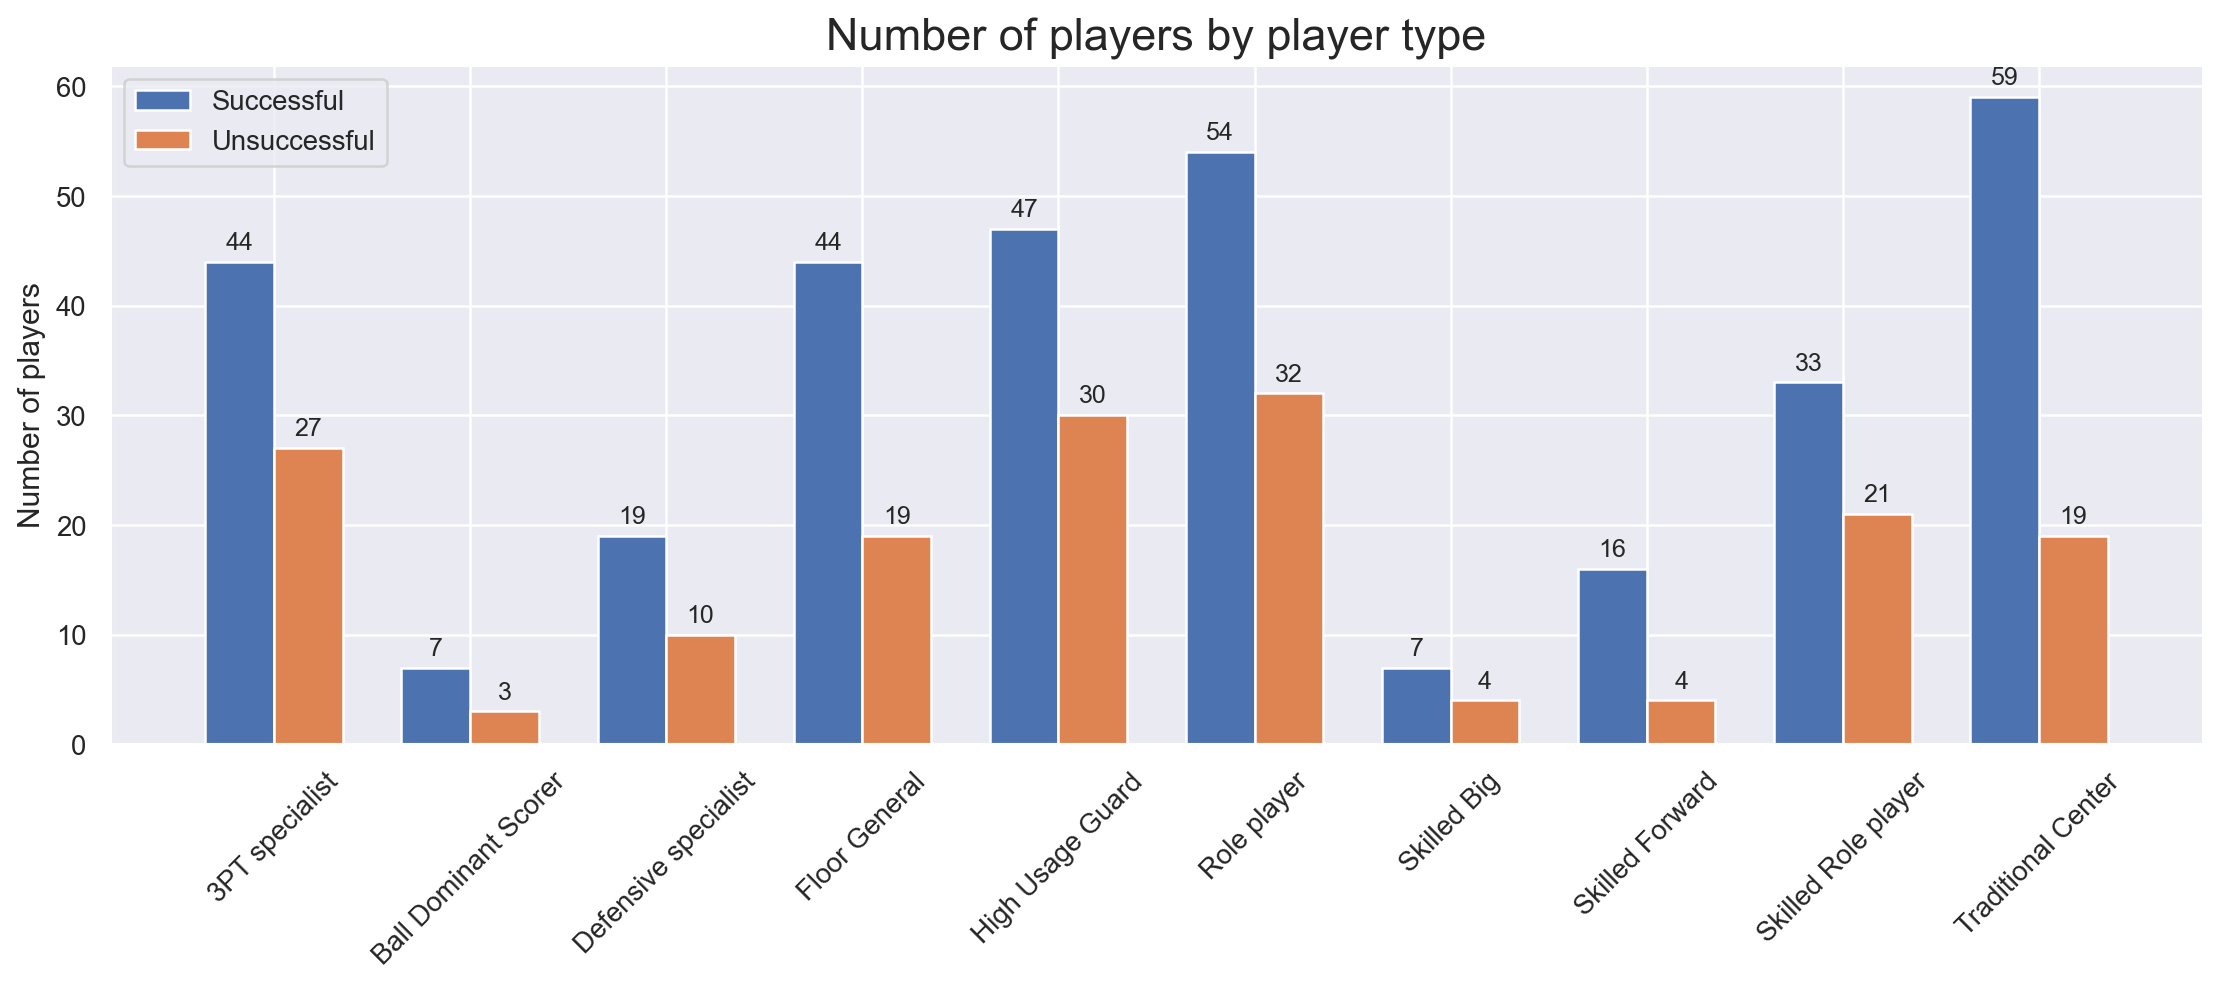

In [1585]:
from matplotlib.pyplot import figure
%matplotlib inline  
labels = type_groups['player type'].unique()

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(15, 5),dpi=180)
rects1 = ax.bar(x - width/2, type_groups[type_groups['success']==1]['n'], width, label='Successful')
rects2 = ax.bar(x + width/2, type_groups[type_groups['success']==0]['n'], width, label='Unsuccessful')

ax.set_ylabel('Number of players')
ax.set_title('Number of players by player type',fontsize=18)
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
plt.xticks(rotation = 45)
plt.show()